<a href="https://colab.research.google.com/github/zaraaa12/Deep_Learning/blob/main/SpeechEmotional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
from IPython.display import Audio


# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print ("Done")


Done


In [ ]:
ravdess = "D:/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
len(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


24

In [ ]:
file_emotion = []
file_path = []

for i in ravdess_directory_list:
    # Get the list of items in the directory
    actor = os.listdir(ravdess + i)
    for f in actor:
        # Construct the full path to check if it's a file
        full_path = os.path.join(ravdess + i, f)

        # Process only files, skip directories
        if os.path.isfile(full_path):
            part = f.split('.')[0].split('-')

            # Check if the file has the expected structure
            if len(part) > 2:  # Ensure part[2] exists
                file_emotion.append(int(part[2]))
                file_path.append(full_path)
            else:
                print(f"Skipping file due to unexpected structure: {f}")

In [ ]:
print(part[0])
print(int(part[2]))
print(file_path[0])
print(f)

03
8
D:/audio_speech_actors_01-24/Actor_01\03-01-01-01-01-01-01.wav
03-01-08-02-02-02-24.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral',
                             2:'calm',
                             3:'happy',
                             4:'sad',
                             5:'angry',
                             6:'fear',
                             7:'disgust',
                             8:'surprise'},
                            inplace=True)


print(ravdess_df.Emotions.value_counts())
print("_______________________________________________")
ravdess_df.head()

Emotions
calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: count, dtype: int64
_______________________________________________


,Emotions,Path
0,neutral,D:/audio_speech_actors_01-24/Actor_01\03-01-01...
1,neutral,D:/audio_speech_actors_01-24/Actor_01\03-01-01...
2,neutral,D:/audio_speech_actors_01-24/Actor_01\03-01-01...
3,neutral,D:/audio_speech_actors_01-24/Actor_01\03-01-01...
4,calm,D:/audio_speech_actors_01-24/Actor_01\03-01-02...


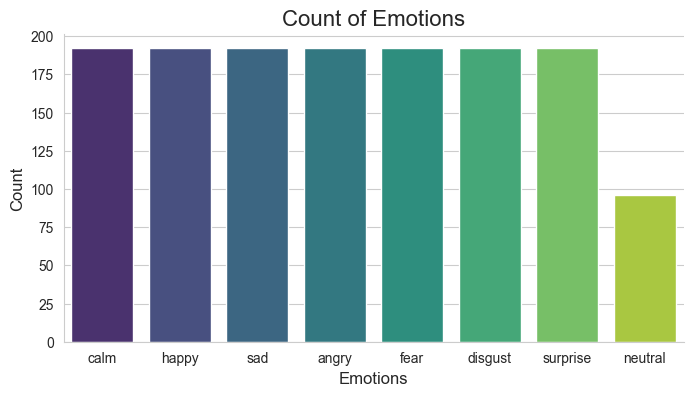

In [ ]:
# Set the plot style
sns.set_style('whitegrid')

# Plot the bar chart
plt.figure(figsize=(8, 4))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=ravdess_df, order=ravdess_df.Emotions.value_counts().index, palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
y, sr = librosa.load(file_path[0]) # sr = sample rate
print(f'y: {y[50000:50010]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00051407 -0.00050618 -0.00059864 -0.0006312  -0.00057561 -0.000542
 -0.00049881 -0.00036658 -0.00037138 -0.00035369]
shape y: (72838,)
sr: 22050


In [ ]:
Audio(file_path[0], autoplay=True)

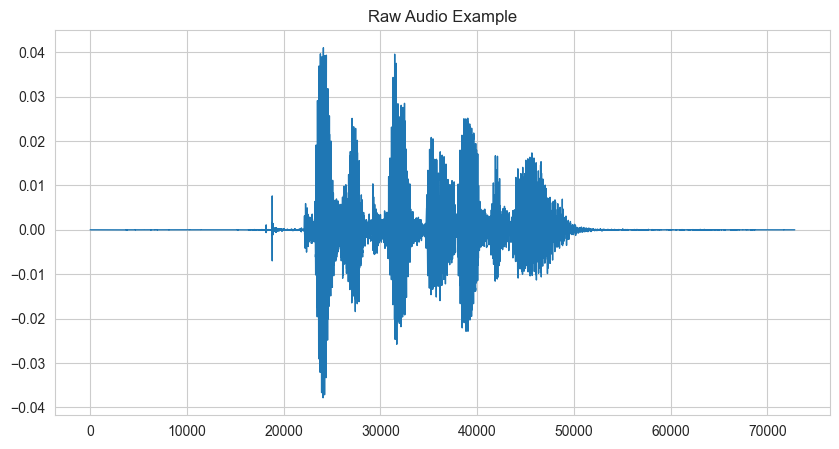

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1, # line width
                  title='Raw Audio Example'
                 )
plt.show()

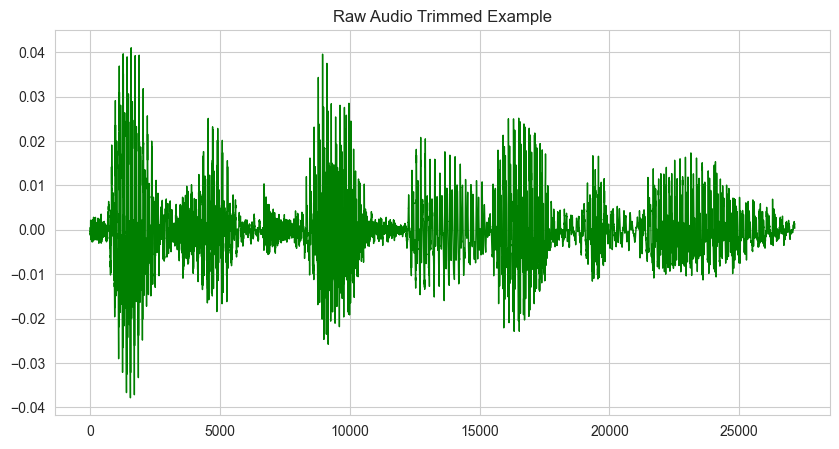

In [ ]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color='green')
plt.show()

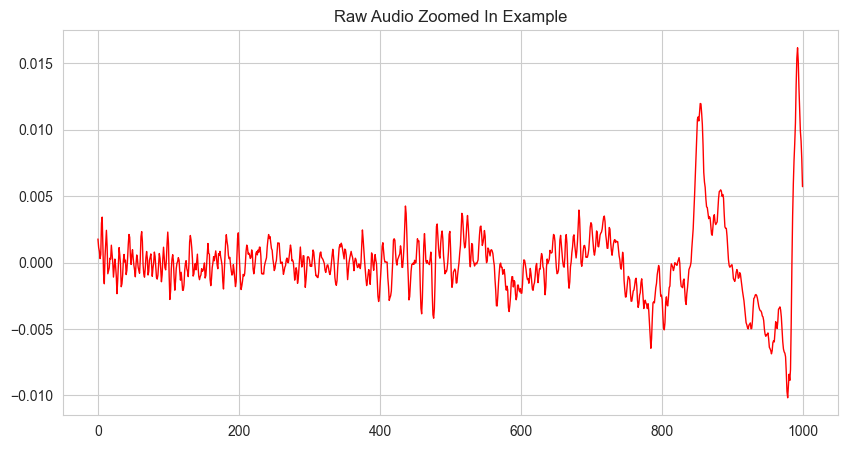

In [ ]:
pd.Series(y[30000:31000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color='red')
plt.show()

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 143)

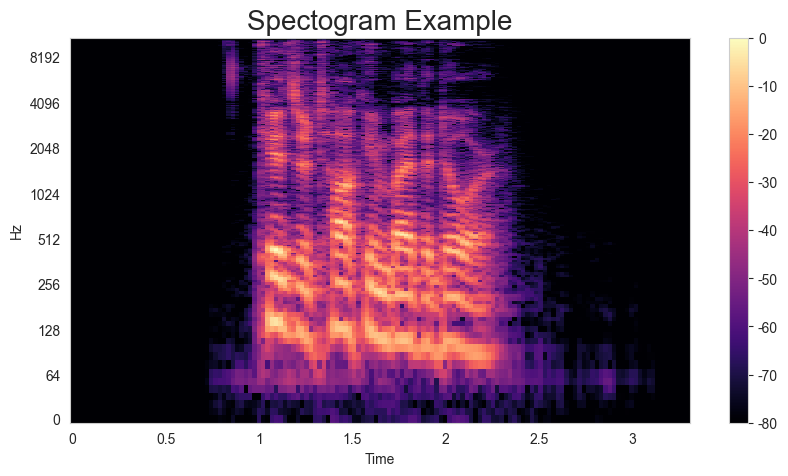

In [ ]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.0f')
plt.show()

In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,
                                   # fmax=8000,
                                  )
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

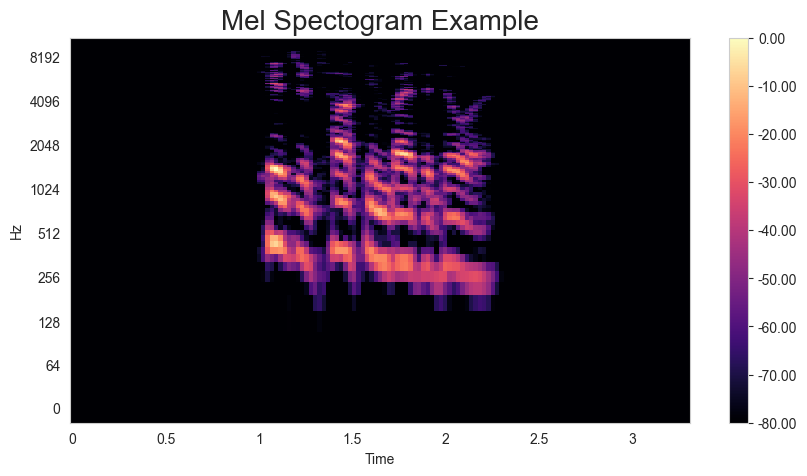

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Compute the STFT for features that require it
    stft_data = np.abs(librosa.stft(data, n_fft=frame_length, hop_length=hop_length))

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length).squeeze()

    # Root Mean Square Energy (RMS)
    rmse = librosa.feature.rms(S=stft_data).squeeze()

    # Mel Spectrogram (use y keyword for data)
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)

    # Mel-Frequency Cepstral Coefficients (MFCC)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), sr=sr, n_mfcc=13).T.ravel()

    # Combine all features into a single array
    return np.hstack([zcr, rmse, mfcc])

def augment_and_extract(data, sr, frame_length=2048, hop_length=512):
    augments = [data, data + 0.005 * np.random.normal(0, 1, len(data)),  # Original + noise
                librosa.effects.pitch_shift(data, sr=sr, n_steps=2),      # Pitched
                librosa.effects.pitch_shift(data + 0.005 * np.random.normal(0, 1, len(data)), sr=sr, n_steps=2)]  # Pitched + noise
    return np.vstack([extract_features(aug, sr, frame_length, hop_length) for aug in augments])

def get_features(path, duration=2.5, offset=0.6, sr=22050, frame_length=2048, hop_length=512):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    return augment_and_extract(data, sr, frame_length, hop_length)

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [ ]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = path_df.Path
emotions = ravdess_df.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  83.21498150000116


In [ ]:
len(X), len(Y), path_df.Path.shape

(5760, 5760, (1440,))

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.816714,0.812341,0.807019,0.800742,0.793534,0.785372,0.776301,0.766315,0.755441,neutral
1,0.240234,0.373535,0.508301,0.508301,0.512695,0.505371,0.503418,0.506348,0.506836,0.512207,...,-0.132596,0.733809,-3.227943,2.523020,2.733629,-1.991238,-4.379277,-0.609574,-1.490641,neutral
2,0.266602,0.369629,0.473633,0.424805,0.378906,0.355957,0.328613,0.376953,0.460938,0.545898,...,1.230156,1.215795,1.198334,1.177833,1.154344,1.127958,1.098741,1.066793,1.032210,neutral
3,0.251465,0.373535,0.497070,0.483887,0.493164,0.486816,0.485840,0.495117,0.484375,0.478516,...,2.782464,4.973956,-0.293541,5.759264,0.963039,2.702119,-4.876504,0.079364,-0.010930,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [ ]:
print(Emotions.isna().sum())

0            0
1            0
2            0
3            0
4            0
            ..
1616        60
1617        60
1618        60
1619        60
Emotions     0
Length: 1621, dtype: int64


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().sum().sum())

0


In [ ]:
#taking last col for Y, which include the emotions
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 1620), (4608, 8), (1152, 1620), (1152, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
model = tf.keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')  # 7 for number of emotion classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1618, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 809, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 809, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 807, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 403, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 403, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 403, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,024 (1.79 MB)

 Trainable params: 470,024 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.1679 - loss: 2.0469 - val_accuracy: 0.2700 - val_loss: 1.9273
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 255s 7s/step - accuracy: 0.2444 - loss: 1.9151 - val_accuracy: 0.3038 - val_loss: 1.8131
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 277s 8s/step - accuracy: 0.3072 - loss: 1.7827 - val_accuracy: 0.3212 - val_loss: 1.7266
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 287s 8s/step - accuracy: 0.3034 - loss: 1.7452 - val_accuracy: 0.3203 - val_loss: 1.7337
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1608s 46s/step - accuracy: 0.3506 - loss: 1.6742 - val_accuracy: 0.3455 - val_loss: 1.6557
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.3645 - loss: 1.6475 - val_accuracy: 0.3359 - val_loss: 1.6685
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 298s 8s/step - accuracy: 0.3686 - loss: 1.6294 - val_accuracy: 0.3793 - val_loss: 1.5964
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 306s 9s/step - accuracy: 0.3679 - loss: 1.6153 - val_accuracy: 0.3759 -

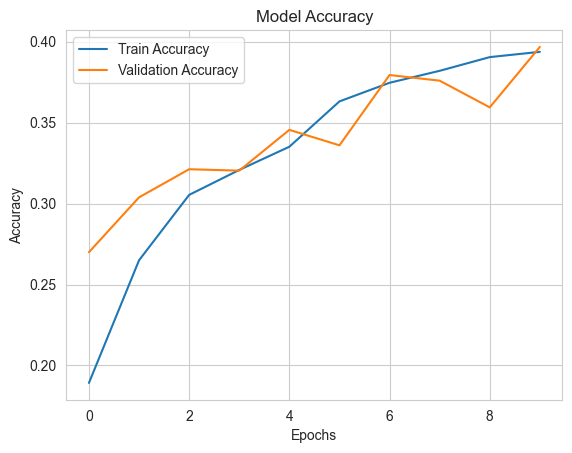

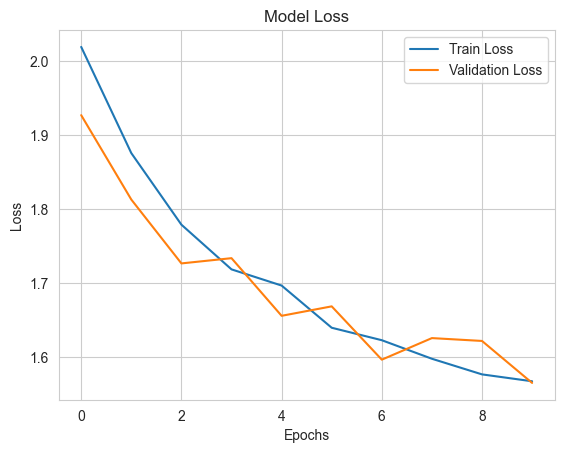

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Save the trained model
model.save('emotion_recognition_model.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('emotion_recognition_model.h5')

In [ ]:
import librosa
import numpy as np
import tensorflow as tf

# Membaca file audio
y, sr = librosa.load("D:/audio_speech_actors_01-24/Actor_06/03-01-02-01-01-01-06.wav")
label = ['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust','surprise']

# Ekstraksi MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mfccs = np.mean(mfccs.T, axis=0)

# Normalisasi fitur
mfccs = np.expand_dims(mfccs, axis=0)

# Memuat model
model = tf.keras.models.load_model('emotion_recognition_model.h5')

# Prediksi untuk audio pertama
prediksi = model.predict(mfccs)
label_prediksi = np.argmax(prediksi)
print("Prediksi untuk audio1:", label[label_prediksi])



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Prediksi untuk audio1: happy


In [ ]:
import librosa
import numpy as np
import tensorflow as tf

def predict_emotion(audio_file):
    try:
        y, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs = np.mean(mfccs.T, axis=0)
        mfccs = np.expand_dims(mfccs, axis=0)

        model = tf.keras.models.load_model('emotion_recognition_model.h5')
        predictions = model.predict(mfccs)
        predicted_emotion = np.argmax(predictions)

        emotion_labels = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',4: 'angry',5:'fear',6:'disgust',7:'suprise'}
        predicted_label = emotion_labels[predicted_emotion]

        return predicted_label

    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# Example usage:
audio_file = "D:/audio_speech_actors_01-24/Actor_06/03-01-03-01-01-01-06.wav"
predicted_label = predict_emotion(audio_file)
print('Predicted Emotion:', predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicted Emotion: happy


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from playsound import playsound
import tkinter as tk
from tkinter import filedialog

def extract_features(audio_file):
    """Mengekstrak fitur MFCC dari file audio."""
    y, sr = librosa.load(audio_file)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

def predict_emotion(audio_file):
    """Memprediksi emosi dari file audio."""
    features = extract_features(audio_file)
    features = np.expand_dims(features, axis=0)

    model = tf.keras.models.load_model('emotion_recognition_model.h5')
    predictions = model.predict(features)
    predicted_emotion_index = np.argmax(predictions)

    emotion_labels = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',4: 'angry',5:'fear',6:'disgust',7:'suprise'}
    predicted_label = emotion_labels[predicted_emotion_index]

    return predicted_label

def browse_file():
    """Membuka dialog untuk memilih file audio."""
    file_path = filedialog.askopenfilename()
    if file_path:
        playsound(file_path)
        predicted_label = predict_emotion(file_path)
        result_label.config(text=f"Emosi yang diprediksi: {predicted_label}")

# Membuat GUI sederhana
root = tk.Tk()
root.title("Emotion Prediction from Audio Files/Prediksi Emosi dari Audio")

label = tk.Label(root, text="Choose File audio to predict/Pilih file audio untuk diprediksi:")
label.pack()

button = tk.Button(root, text="Choose File/Pilih File", command=browse_file)
button.pack()

# Label untuk menampilkan hasil prediksi
result_label = tk.Label(root, text="", font=("Helvetica", 16))
result_label.pack()

root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
